# Fit of the intensity profiles for single stars

In this notebook, we demonstrate how to determine the line profile parameters that will be use to generate the synthetic Stokes V profile, base on a modelling of the Stokes I profiles. 

## 0. Importing the necessary packages

In [1]:
import pandas as pd
#import itertools
from IPython.display import display
import pyRaven as rav
import matplotlib.pyplot as plt
import h5py as h5
import json
import numpy as np

## 1. Opening the information spreadsheets, and loading the DataPacked created in the previous tutorial

For this example, we will again use the spreadsheets from the data_example notebook, that contains some informations about the stars in the sample, as well as the observations for eachs stars.  



In the cell below, we open the spreadsheets, and select the rows containing the information for the star HD 13745. (see the previous tutorials for some tips on how to used to functionality of Pandas to automate your processing with loops).

In [2]:
sheet_id = "1fHcSEr-hUV-VQ1bH9DjDppJQvZ-K9PzX5DRjnpKPbUk"
sheet_name = "Stars"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_stars = pd.read_csv(url)

sheet_name = "Observations"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_obs = pd.read_csv(url)

# Star contains the row for HD 13745
star = df_stars.loc[df_stars["StarName"]=='hd13745']

# selecting the rows in the observation dataframe where the star name matches
obs = df_obs.loc[df_obs["StarName"]=='hd13745']

In the cell below, we load the DataPacket that we created in the previous tutorial

In [3]:
DataPacket = rav.data.read_packet('ExampleData/ExamplePacket.h5')

## 2. Creating a parameter dictionary for the intensity profile fitting

A lot of the main codes in pyRaven rely on a dictionary to pass the necessary parameters necessary for computations (see LINK for details). 

As a simple introduction here, we demonstrate two ways of creating these dictionaries (default parameter function, and direct dictionary creation), as well as how to write to file (and read back)in .json format. 

In the cell below, we use the `params.get_def_param_fitI()` function to return a typical dictionary suitable for a calculation of the intensity profile. 
We use the `pprint` method to do a pretty-print of the dictionary. 
We also illustrate quickly how to edit the value of a key in a dictionary. 

As you can see, `param` is a dictionary of sub-dictionaries (as explained ADD LINK). For the calculation of intensity profiles with the ADD FUNCTION function, we only need some elements in the `"general"` sub-dictionary (we would need additional sub-dictionaries if we were making Stokes V calculations, for example). 

In [4]:
param = rav.params.get_def_param_fitI()

param.pprint()

param["general"]["vsini"]=40.0

param.pprint()

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}
{
  "general": {
    "lambda0": 5000,
    "vsini": 40.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}


In the cell below, we provide an alternative method to create a `parameter` dictionary object. We first create the dictionary that contains the necessary keywords in the `"general"` sub-dictionary. As we only need this sub-dictionary for the intensity profile calculations below, we then create the main dictionary with only the 'general' sub-dictionary. We use the `params.parameters(dict)` class to create a `parameters` object (which is simply a regular dictionary with a few add-ons) so that we can use the `pprint()` method afterwards (but this is not strickly necessary to use the pyRaven calculation codes)

In [5]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':50.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':0.98,          # the line strength parameter
    'ndop':int(10)      # the number of sample point per doppler width for the wavelength array
  }

param=rav.params.parameters({'general' : genparam})

param.pprint()

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}


In the cell below, we illustrate how to use the `write` method of the `parameters` dictionary class to write the information to a .json file for safe-keeping. 

We chose to use the json format because they are human-readable. 

In [6]:
param.write('ExampleData/FitI_param.json')

In the cell below, we show how to read back these .json files back into a `parameters` dictionary object.

As the json format is easily human-readable, it is also possible to use these files as input files to create your parameters dictionaries. (However, please note the subtleties with python lists versus numpy arrays described in ADD LINK, especially for the parameters related to the unno zeeman parameters and the loop grid parameters).

In [7]:
param = rav.params.read_parameters('ExampleData/FitI_param.json')

param.pprint()

{
  "general": {
    "av": 0.05,
    "bnu": 1.5,
    "lambda0": 5000,
    "logkappa": 0.98,
    "ndop": 10,
    "vdop": 10.0,
    "vsini": 50.0
  }
}


## 3. Fitting kappa, vsini, and vmac

The `fitparams.py` module contains two functions that can fit kappa, vsini, and vmac. We must first set up our param dictionary and DataPacket. The param set up works exactly the same as above. You can create one by hand, load one from a `.json` file, or change one of the defualt param dictionaries. In this example, we will use the latter. 

We also need to read in a DataPacket as was done above.

In [8]:
param = rav.params.get_def_param_fitI()
param['general'].update({'res': 65000.})
param['general'].update({'vmac': 10.})
param.pprint()

DataPacket = rav.data.read_packet('ExampleData/ExamplePacket.h5')

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000.0,
    "vmac": 10.0
  }
}


The first method for fitting the three values is using scipy's `curve_fit` function. We can pass the param dictionary, DataPacket, and an arry containing guess values of kappa, vsini, and vmac to `rav.fitparams.fitdata`. This will output an array with the three values (saved as `parameters` below), the covariance matrix (`covariance`), and the model output from `rav.diskint2.analytical` (`modelout`).

In [9]:

guess=np.array([1.3,DataPacket.vsini,30])

parameters,covariance,modelout = rav.fitparams.fitdata(param,DataPacket,guess)
print(parameters)


[  0.83346133 184.25974318  41.54344531]


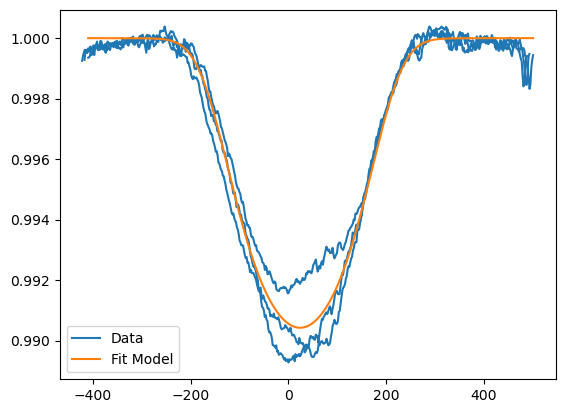

In [10]:
x1=DataPacket.scaled.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.scaled.lsds[0].specI
x2=DataPacket.scaled.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.scaled.lsds[1].specI
x3=DataPacket.scaled.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.scaled.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

Additionally, we can also perform a fit of kappa and vmac while keeping vsini fixed. This is done by using the `fitdata_novsini` function as done below.

In [11]:

guess=np.array([1.3,30])

parameters,covariance,modelout = rav.fitparams.fitdata_novsini(param,DataPacket,guess)
print(parameters)


[ 0.84514852 95.43467454]


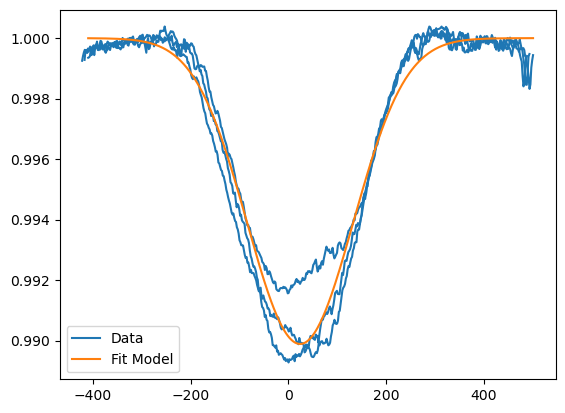

In [12]:
x1=DataPacket.scaled.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.scaled.lsds[0].specI
x2=DataPacket.scaled.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.scaled.lsds[1].specI
x3=DataPacket.scaled.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.scaled.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

## 4. Simultaneous fitting of a binary star profile

We can also perform a simultaneous fit on a binary line profile. Below we create a synthetic binary line profile that might be calculated from a spectroscopic binary system. 

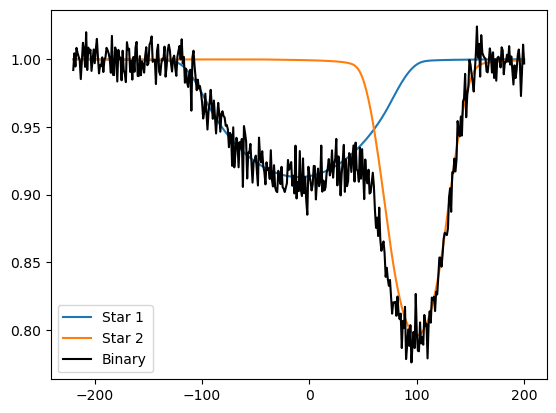

In [54]:
#set up star 1's parameters
param1 = rav.params.get_def_param_fitI()
param1["general"]["vsini"]=100.0

#set up star 2's parameters
param2 = rav.params.get_def_param_fitI()
param2["general"]["vsini"]=40.0

#create the fake profile of each individual star
model1=rav.diskint2.analytical(param1,False)
model2=rav.diskint2.analytical(param2,False)
vrad2=100
vrad1=-10
model1['vel']=model1['vel']+vrad1
f=np.interp(model1['vel'],model2['vel']+vrad2,model2['flux'])

#create the fake binary profile
binary=model1['flux']+f-1
snr = 100
sigma = 1/snr
binary = binary + np.random.normal(0, sigma, binary.size)

plt.plot(model1['vel'],model1['flux'],c='C0',label='Star 1')  
plt.plot(model1['vel'],f,c='C1',label='Star 2')
plt.plot(model1['vel'],binary,c='black',label='Binary')
plt.legend()

We can then call the `binary_fitting` function. This function takes in:
* xs - list of velocity arrays of each observation of the observed profile
* ys - list of specI arrays of each observation of the observed profile
* guess - array with guess parameters. Format: np.array([kappa1,kappa2,vsini1,vsini2,vmac1,vmac2,vrad1_1,vrad2_1,vrad1_2,vrad2_2,...])
* param1 - initial lsd parameters for star 1
* param2 - initial lsd parameters for star 2

For this first example we only have one observation. This function outputs:
* pout - array with the best fit parameters in the same format at guess
* pcov - corresponding covariance matrix
* binary_models - array of flux models of the binary at each observation
* star1_models - array of flux models of star 1 at each observation
* star2_models - array of flux models of star 2 at each observation

By printing `pout` we can see the fit values for the stellar parameters.

[  2.58532449   2.67689155  98.99999226  41.44842478   9.56370933
   0.2        -10.99808571  99.68704115]


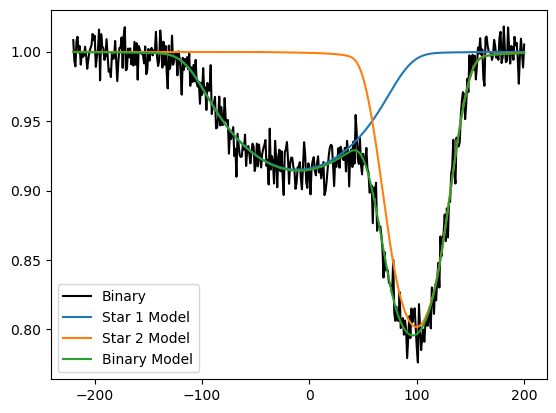

In [53]:
xs=[model1['vel']] #velocity arrays of our observations
ys=[binary] #flux arrays of our observations
guess=np.array([0.2,0.3,80,40,10,10,-10,50]) #our guess parameters in the specified format
pout,pcov,binary_models,star1_models,star2_models=rav.fitparams.binary_fitting(xs,ys,guess,param1,param2)
print(pout)
kappa1=pout[0]
kappa2=pout[1]
vsini1=pout[2]
vsini2=pout[3]
vmac1=pout[4]
vmac2=pout[5]

plt.plot(model1['vel'],binary,c='black',label='Binary')
plt.plot(model1['vel'],star1_models[0][0],c='C0',label='Star 1 Model')  
plt.plot(model1['vel'],star2_models[0][0],c='C1',label='Star 2 Model')
plt.plot(model1['vel'],binary_models[0][0],c='C2',label='Binary Model')

plt.legend()


This routine can also perform a simultaneous fit of multiple observations. This will force the kappa, vsini, and vmac values to star the same between observations for each star while allowing the vrads to change between observations. This is done automatically by passing more than one observation in `xs` and `ys. In the cell below three observations of a fake star a made.

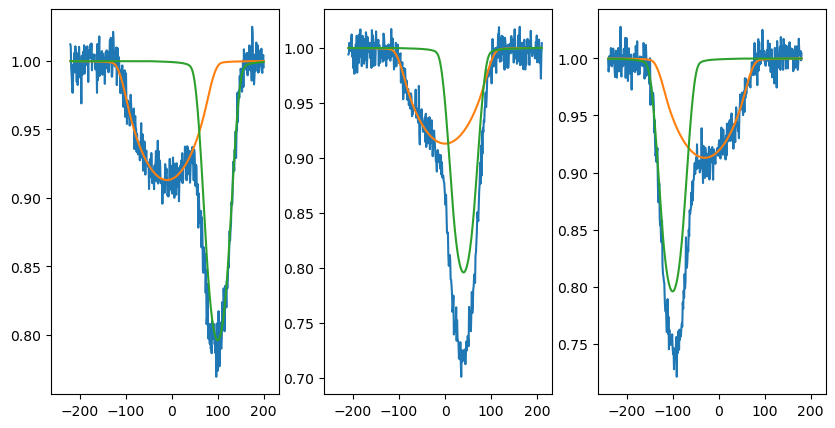

In [55]:
#set up star 1's parameters
param1 = rav.params.get_def_param_fitI()
param1["general"]["vsini"]=100.0

#set up star 2's parameters
param2 = rav.params.get_def_param_fitI()
param2["general"]["vsini"]=40.0

#create the fake profile of each individual star (observation 1)
model1_1=rav.diskint2.analytical(param1,False)
model2_1=rav.diskint2.analytical(param2,False)
vrad2_1=100
vrad1_1=-10
model1_1['vel']=model1_1['vel']+vrad1_1
f_1=np.interp(model1_1['vel'],model2_1['vel']+vrad2_1,model2_1['flux'])
#create the fake binary profile (observation 1)
binary_1=model1_1['flux']+f_1-1
snr = 100
sigma = 1/snr
binary_1 = binary_1 + np.random.normal(0, sigma, binary_1.size)

#create the fake profile of each individual star (observation 2)
model1_2=rav.diskint2.analytical(param1,False)
model2_2=rav.diskint2.analytical(param2,False)
vrad2_2=40
vrad1_2=0
model1_2['vel']=model1_2['vel']+vrad1_2
f_2=np.interp(model1_2['vel'],model2_2['vel']+vrad2_2,model2_2['flux'])
#create the fake binary profile (observation 2)
binary_2=model1_2['flux']+f_2-1
snr = 100
sigma = 1/snr
binary_2 = binary_2 + np.random.normal(0, sigma, binary_2.size)

#create the fake profile of each individual star (observation 3)
model1_3=rav.diskint2.analytical(param1,False)
model2_3=rav.diskint2.analytical(param2,False)
vrad2_3=-100
vrad1_3=-30
model1_3['vel']=model1_3['vel']+vrad1_3
f_3=np.interp(model1_3['vel'],model2_3['vel']+vrad2_3,model2_3['flux'])
#create the fake binary profile (observation 3)
binary_3=model1_3['flux']+f_3-1
snr = 100
sigma = 1/snr
binary_3 = binary_3 + np.random.normal(0, sigma, binary_3.size)

fig, ax = plt.subplots(1,3,sharex=True,figsize=(10,5))

ax[0].plot(model1_1['vel'],binary_1)
ax[0].plot(model1_1['vel'],model1_1['flux'])
ax[0].plot(model1_1['vel'],f_1)


ax[1].plot(model1_2['vel'],binary_2)
ax[1].plot(model1_2['vel'],model1_2['flux'])
ax[1].plot(model1_2['vel'],f_2)


ax[2].plot(model1_3['vel'],binary_3)
ax[2].plot(model1_3['vel'],model1_3['flux'])
ax[2].plot(model1_3['vel'],f_3)


In the next cell we will perform the fit. In inputs are the same as before except we are inputing more observations in the `xs` and `ys` arrays, and more vrads in the `guess` array.

[  2.6359295    2.69792933  99.60602723  39.99999737   2.96651328
   4.74480065  -9.29526339 100.0626626   -0.25466608  40.13229157
   0.87478866 -70.38194886]


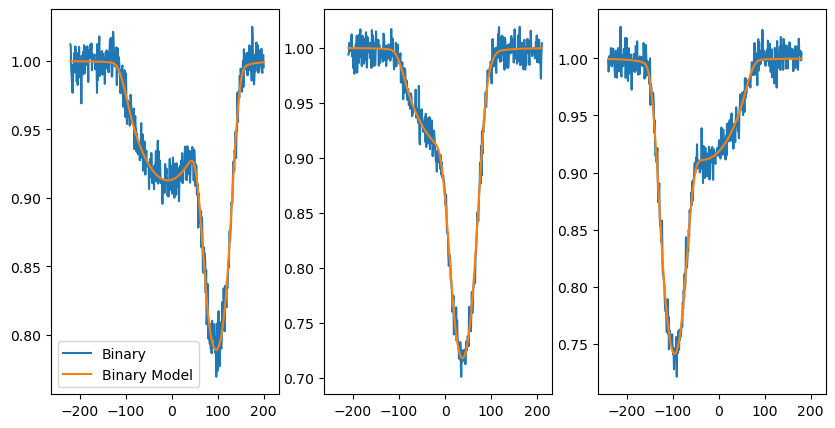

In [59]:
xs=[model1_1['vel'],model1_2['vel'],model1_2['vel']] #velocity arrays of our observations
ys=[binary_1,binary_2,binary_3] #flux arrays of our observations
guess=np.array([0.2,0.3,80,40,10,10,-10,50,-10,50,10,-50]) #our guess parameters in the specified format
pout,pcov,binary_models,star1_models,star2_models=rav.fitparams.binary_fitting(xs,ys,guess,param1,param2)
print(pout)
kappa1=pout[0]
kappa2=pout[1]
vsini1=pout[2]
vsini2=pout[3]
vmac1=pout[4]
vmac2=pout[5]


fig, ax = plt.subplots(1,3,sharex=True,figsize=(10,5))

ax[0].plot(model1_1['vel'],binary_1,label='Binary')
ax[0].plot(model1_1['vel'],binary_models[0][0],label='Binary Model')
ax[0].legend()

ax[1].plot(model1_2['vel'],binary_2)
ax[1].plot(model1_2['vel'],binary_models[1][0])


ax[2].plot(model1_3['vel'],binary_3)
ax[2].plot(model1_3['vel'],binary_models[2][0])